In [1]:
import numpy as np
from scipy.io import loadmat
import sys
sys.path.insert(0, '/home/agogliet/gogliettino/projects/papers/raphe/repos/raphe-vs-periphery/')
import src.dataset as d
import src.config as cfg
import src.fitting as fit
import importlib as il
import src.lnp as lnp
import src.io_util as io
import src.fitting as fit
import src.recon as recon
import os
import visionloader as vl
import matplotlib.pyplot as plt
from scipy import stats
import cv2
from scipy.optimize import curve_fit

In [2]:
def calculate_sig_stixels(sta, num_frames=9, alpha=1/10000, color_channels=None):
    """
    Sam Cooler sig stix implementation.

    Parameters:
        sta: STA of size t,y,x,c, with zero mean!
        num_frames: frames to use in noise calculation
        alpha: significance level
        color_channels: color channels to use
    Returns: tuple of booleans denoting the sig stix and the p values.
    
    Flips the STA and re-orders dims, but changes it back (doesn't mutate).

    """
    # Rearrange the dims and flip.
    sta = np.flip(np.moveaxis(sta,0,-2),axis=-2)

    if color_channels is None:
        color_channels = (0,1,2)

    early_frames = np.mean(sta[...,0:num_frames,color_channels], 3) 
    #std_this_cell = stats.median_absolute_deviation(early_frames.flatten())
    std_this_cell = stats.median_abs_deviation(early_frames.flatten())

    # Mean over color, square, sum over time
    input_frame = np.sum(np.power(np.mean(sta[...,-(num_frames+1):-1,
                               color_channels],3) / std_this_cell, 2), 2)

    # Chi squares survival = 1 - CDF
    pvalues = stats.chi2(df=num_frames).sf(input_frame) + np.finfo(float).eps 
    pvalues *= (sta.shape[0] * sta.shape[1]) # bonferroni correction

    # Put it back in order.
    sta = np.flip(np.moveaxis(sta,-2,0),axis=0)

    return pvalues < alpha, pvalues

## Get the gsorted cells

In [3]:
GSORT_BASE = "/Volumes/Scratch/Analysis"
ANALYSIS_BASE = "/Volumes/Analysis"
dataset = "2020-10-18-0"
wnoise = "kilosort_data000/data000"
estim_neg = "data001"
outpath = os.path.join(GSORT_BASE, dataset, estim_neg, wnoise)

vcd = vl.load_vision_data(f'/Volumes/Analysis/{dataset}/{wnoise}',
                          os.path.basename(wnoise),
                          include_ei=True,
                          include_neurons=True,
                          include_params=True,
                          include_sta=True)

parameters = loadmat(os.path.join(outpath, 'parameters.mat'))
cells = parameters['cells'].flatten()
gsorted_cells = parameters['gsorted_cells'].flatten()

gsorted_cells_new = []
for i in range(len(gsorted_cells)):
    if 'parasol' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
        gsorted_cells_new.append(gsorted_cells[i])
    # if 'midget' in vcd.get_cell_type_for_cell(cells[gsorted_cells[i]]).lower():
    #     gsorted_cells_new.append(gsorted_cells[i])

gsorted_cells = np.array(gsorted_cells_new)
cells_to_use = cells[gsorted_cells]

## Constants

In [4]:
RESAMPLE_X = 320 # 80
RESAMPLE_Y = 160 # 40
ALPHA = 1/100000

In [5]:
stas = []
stas_fit = []
bad_cells = []

for cell in cells_to_use:
    sta = vcd.get_sta_for_cell(cell) 
    sta = np.stack([sta.red,sta.green,sta.blue])
    sta = np.swapaxes(sta,0,-1)
    
    # Resample the STA
    sta = np.asarray([cv2.resize(sta[i,...],(RESAMPLE_X,RESAMPLE_Y),interpolation=cv2.INTER_CUBIC)
           for i in range(sta.shape[0])
          ])
    sig_stix = calculate_sig_stixels(np.flip(sta,axis=0) - np.mean(sta),alpha=ALPHA)
    sta -= np.mean(sta)
    mask = sig_stix[0].astype(int)
    tc = np.sum(sta * mask[None,...,None],axis=(-1,-2,-3))
    sta = np.mean(sta[np.argmax(np.abs(tc)),...],axis=-1)
    
    # Fit 2d Gaussian.
    popt = fit.fit_gaussian2d(sta[...,None],np.argwhere(sig_stix[0]))
    
    if popt is None:
        bad_cells.append(cell)
        continue
        
    orig_n_pixels_x = sta.shape[1]
    orig_n_pixels_y = sta.shape[0]
    x = np.linspace(0,orig_n_pixels_x-1,RESAMPLE_X)
    y = np.linspace(0,orig_n_pixels_y-1,RESAMPLE_Y)
    xx,yy = np.meshgrid(x,y)
    out = fit.gaussian2d((xx,yy),*popt)
    out = recon.mask_gaussian_filter(out,popt,xx,yy,4)
    stas_fit.append(out)
    stas.append(sta)
    
stas = np.asarray(stas)
stas_fit = np.asarray(stas_fit)

## Scale the STAs

In [6]:
try:
    encoding_filters = np.load(f'encoding_filters_{dataset}.npy')
except:
    encoding_filters = recon.get_encoding_filters_pooled(stas_fit,
                                               inds=[np.arange(0,stas.shape[0])],
                                               firing_rates=[3],
                                                stixels=cfg.STIXEL_SIZES)
    np.save(f'encoding_filters_{dataset}.npy', encoding_filters)

## Compute reconstruction filters

In [7]:
try:
    decoding_filters = np.load(f'decoding_filters_{dataset}.npy')
except:
    decoding_filters = recon.learn_recon_filters_pooled(encoding_filters.reshape(-1,RESAMPLE_Y,RESAMPLE_X))
    np.save(f'decoding_filters_{dataset}.npy', decoding_filters)

In [ ]:
for i in range(decoding_filters.shape[0]):
    plt.figure()
    plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
    plt.show()

## Do greedy ..

In [8]:
mask = (np.sum(np.abs(encoding_filters),axis=0)!=0).astype(int)
sig_stix = np.argwhere(mask).flatten()

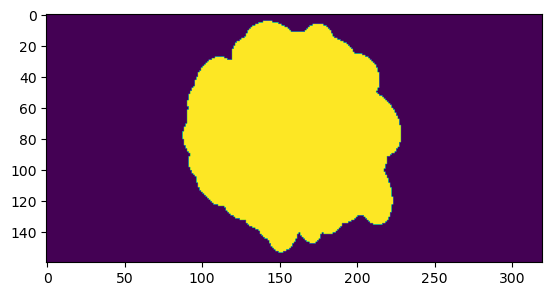

In [9]:
plt.imshow(mask.reshape(160,320))

In [10]:
dictionary_matrix = np.load(f'estim_dictionary_1elec_{dataset}.npy')
var_dict = recon.get_dictionary_variance(dictionary_matrix.T,decoding_filters)

In [11]:
NUM_REPEATS = 100
SE_map_avg = np.zeros(decoding_filters.shape[1])
error_proj_cutoff = 0.15
error_proj_all = []
bad_cells_all = []

for i in range(NUM_REPEATS):
    print(f'Repeat {i+1}')
    test_stimulus_vector = recon.get_random_stimuli_jitter(1, 32, RESAMPLE_X, RESAMPLE_Y)

    # plt.figure()
    # plt.imshow(test_stimulus_vector[:, :, 0] * mask.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    greedy_out = recon.greedy_stim(dictionary_matrix.T,decoding_filters,var_dict,
                                sig_stix,test_stimulus_vector)
    masked_expt = greedy_out['decoded_stimuli'].flatten() * mask

    masked_opt = (recon.get_optimal_recon(decoding_filters, 
                            test_stimulus_vector[:, :, 0].reshape(160*320, 1), mask).flatten() *
                  mask)

    # plt.figure()
    # plt.imshow(masked_expt.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    # plt.figure()
    # plt.plot(greedy_out['error_log'])
    # plt.show()

    # plt.figure()
    # plt.imshow(masked_opt.reshape(160,320),cmap='gray')
    # plt.xlim([70,250])
    # plt.show()

    # plt.figure()
    # plt.plot(greedy_out_opt['error_log']) 
    # plt.show()

    target = test_stimulus_vector[:, :, 0] * mask.reshape(160,320)

    SE_map = (masked_opt - masked_expt)**2/np.linalg.norm(target, ord='fro')**2
    # plt.figure()
    # plt.imshow(SE_map.reshape(160, 320))
    # plt.xlim([70,250])
    # plt.show()

    cell_products = np.zeros(decoding_filters.shape[0])
    for i in range(decoding_filters.shape[0]):
        # plt.figure()
        # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
        # plt.show()

        pixel_mask = (encoding_filters[i, :] != 0).astype(int)

        # plt.figure()
        # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
        # plt.show()

        cell_products[i] = ((decoding_filters[i, :] * pixel_mask)**2 @ SE_map / 
                            (np.linalg.norm(SE_map) * np.linalg.norm((decoding_filters[i, :] * pixel_mask)**2)))
    
    error_proj_all.append(cell_products)
    bad_cell_inds = np.where(cell_products > error_proj_cutoff)[0]
    bad_cells_all.append(bad_cell_inds)
    print(bad_cell_inds)

    SE_map_avg += SE_map

SE_map_avg = SE_map_avg / NUM_REPEATS

Repeat 1
stimulation: 0, error: 3456.407
stimulation: 500, error: 2763.223
converged after 918 total stimulations.
DEBUG
[  9  10  77  92 121 133 165 175 192 193 197 199]
Repeat 2
stimulation: 0, error: 3457.456
stimulation: 500, error: 2649.164
converged after 712 total stimulations.
DEBUG
[ 13  34  36  48  52  73  83  88 118 149 175 178 181 193 208]
Repeat 3
stimulation: 0, error: 3458.496
stimulation: 500, error: 2631.359
converged after 618 total stimulations.
DEBUG
[  9  19  45  56  86 100 101 110 148 149 169 182 199 201]
Repeat 4
stimulation: 0, error: 3454.548
stimulation: 500, error: 2602.402
converged after 881 total stimulations.
DEBUG
[ 37  52  57  59 105 121 135 162 166 175 179]
Repeat 5
stimulation: 0, error: 3454.317
stimulation: 500, error: 2488.014
converged after 762 total stimulations.
DEBUG
[  0   2  37  52  59  83  87  88  93 102 149 168 181]
Repeat 6
stimulation: 0, error: 3463.556
stimulation: 500, error: 2762.476
converged after 995 total stimulations.
DEBUG
[ 37

In [12]:
unique_cells, counts = np.unique(np.concatenate(bad_cells_all), return_counts=True)

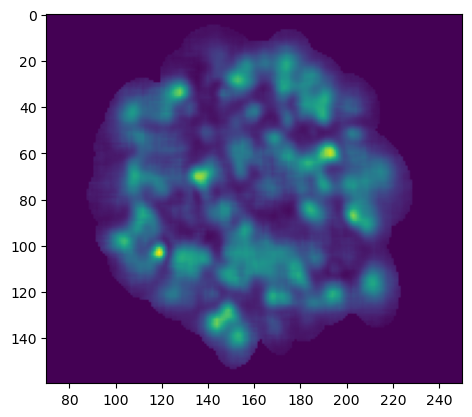

In [13]:
plt.figure()
plt.imshow(SE_map_avg.reshape(160, 320))
plt.xlim([70,250])
plt.show()

In [14]:
np.save(f'SE_map_avg_{dataset}.npy', SE_map_avg)

In [15]:
test_stimulus_vector = recon.get_random_stimuli_jitter(1, 32, RESAMPLE_X, RESAMPLE_Y)

(70.0, 250.0)

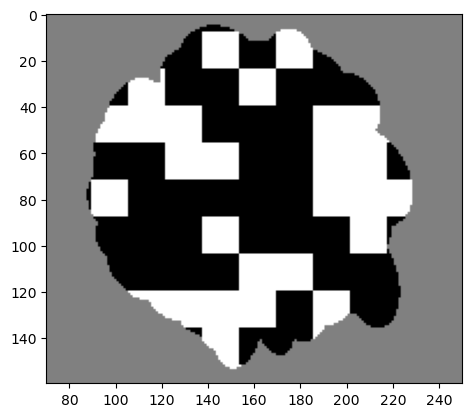

In [16]:
plt.imshow(test_stimulus_vector[:, :, 0] * mask.reshape(160,320),cmap='gray')
plt.xlim([70,250])

In [17]:
greedy_out = recon.greedy_stim(dictionary_matrix.T,decoding_filters,var_dict,
                                sig_stix,test_stimulus_vector)

stimulation: 0, error: 3463.696
stimulation: 500, error: 2586.469
converged after 745 total stimulations.


In [18]:
masked_expt = greedy_out['decoded_stimuli'].flatten() * mask
masked_opt = (recon.get_optimal_recon(decoding_filters, 
                            test_stimulus_vector[:, :, 0].reshape(160*320, 1), mask).flatten() *
                  mask)

DEBUG


(70.0, 250.0)

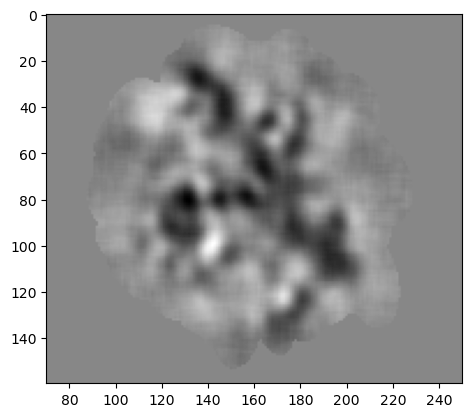

In [19]:
plt.imshow(masked_expt.reshape(160,320),cmap='gray')
plt.xlim([70,250])

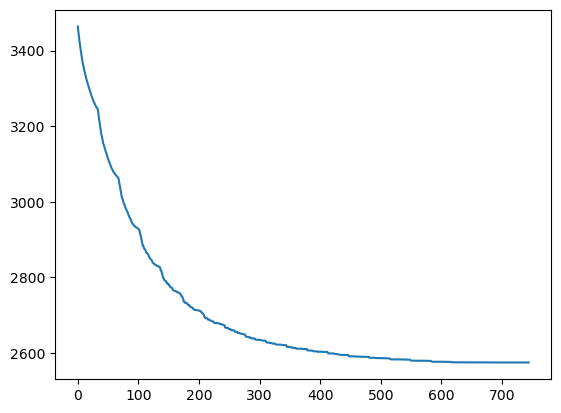

In [20]:
plt.plot(greedy_out['error_log'])

(70.0, 250.0)

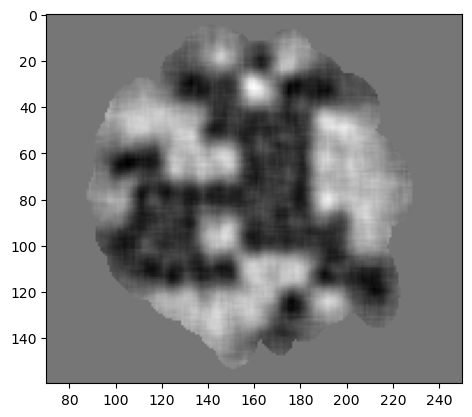

In [21]:
plt.imshow(masked_opt.reshape(160,320),cmap='gray')
plt.xlim([70,250])

In [22]:
target = test_stimulus_vector[:, :, 0] * mask.reshape(160,320)

(70.0, 250.0)

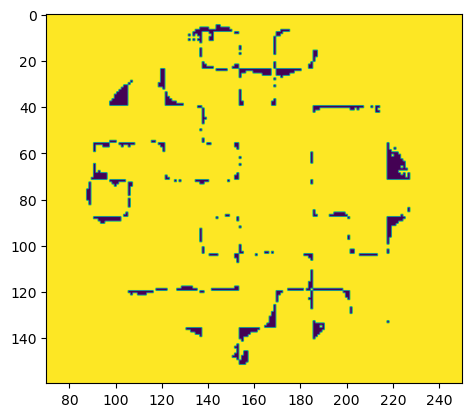

In [23]:
plt.imshow((np.sign(target) == np.sign(masked_opt.reshape(160, 320))).astype(int))
plt.xlim([70,250])

(70.0, 250.0)

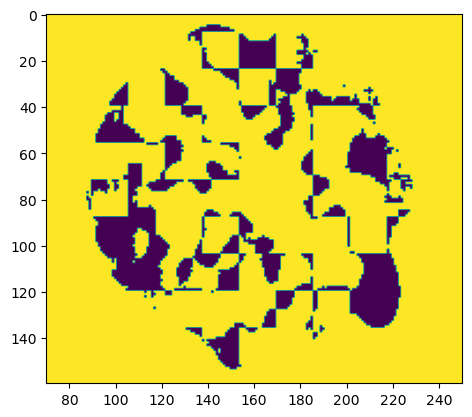

In [24]:
plt.imshow((np.sign(target) == np.sign(masked_expt.reshape(160, 320))).astype(int))
plt.xlim([70,250])

(70.0, 250.0)

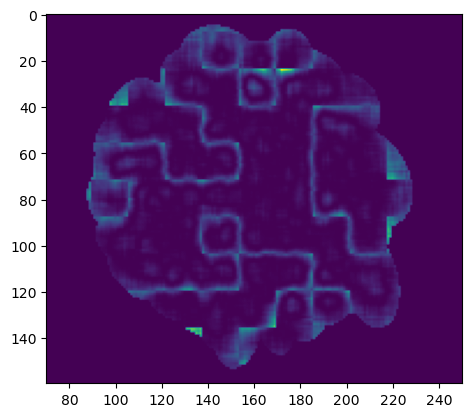

In [25]:
plt.imshow((target - masked_opt.reshape(160, 320))**2/np.linalg.norm(target, ord='fro')**2)
plt.xlim([70,250])

In [26]:
element_contrib = (dictionary_matrix.T @ decoding_filters)**2

In [27]:
error_proj = (element_contrib @ SE_map_avg)

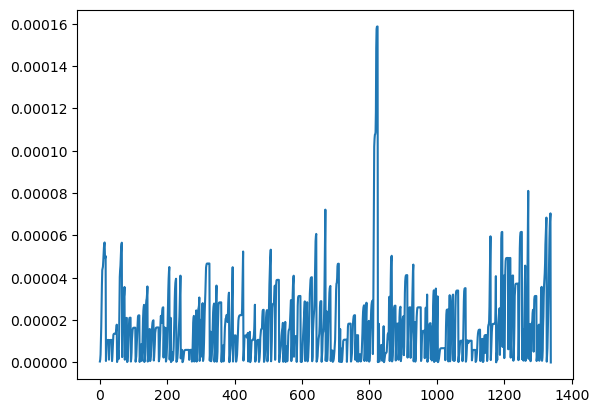

In [28]:
plt.figure()
plt.plot(error_proj)

Text(0, 0.5, '# Nonzero Probabilities in Element')

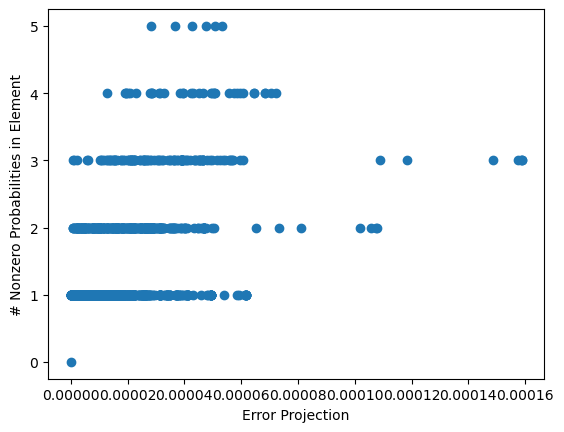

In [29]:
plt.figure()
plt.scatter(error_proj, np.count_nonzero(dictionary_matrix, axis=0))
plt.xlabel('Error Projection')
plt.ylabel('# Nonzero Probabilities in Element')

Text(0, 0.5, 'Number of Nonzero probabilities in element')

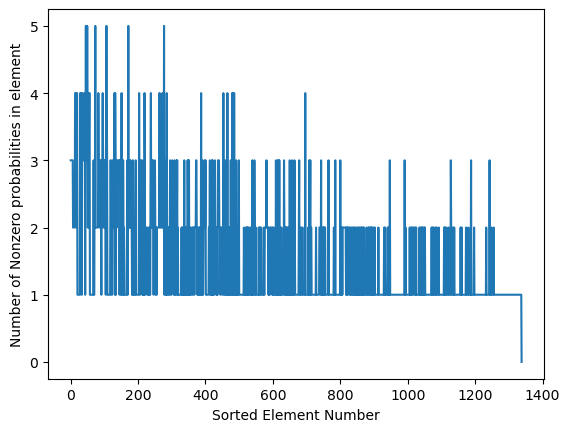

In [30]:
plt.plot(np.count_nonzero(dictionary_matrix[:, np.flip(np.argsort(error_proj))], axis=0))
plt.xlabel('Sorted Element Number')
plt.ylabel('Number of Nonzero probabilities in element')

In [31]:
from copy import deepcopy

In [32]:
dictionary_matrix_sorted = deepcopy(dictionary_matrix[:, np.flip(np.argsort(error_proj))])

In [33]:
rows_with_nonzero = {}

for col in range(dictionary_matrix_sorted.shape[1]):
    rows_with_nonzero[col] = np.where(dictionary_matrix_sorted[:, col] != 0)[0]

In [34]:
problem_cells = []
for col in range(dictionary_matrix_sorted.shape[1]):
    for ind in rows_with_nonzero[col]:
        if ind not in problem_cells:
            problem_cells.append(ind)
problem_cells = np.array(problem_cells)

In [35]:
len(problem_cells)

131

[ 94 100 196 153 161  69  70  72  73 176]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2545.438
converged after 698 total stimulations.


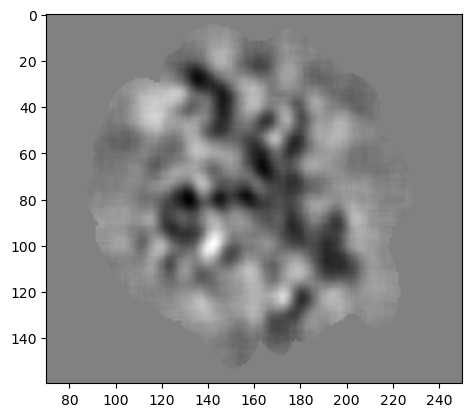

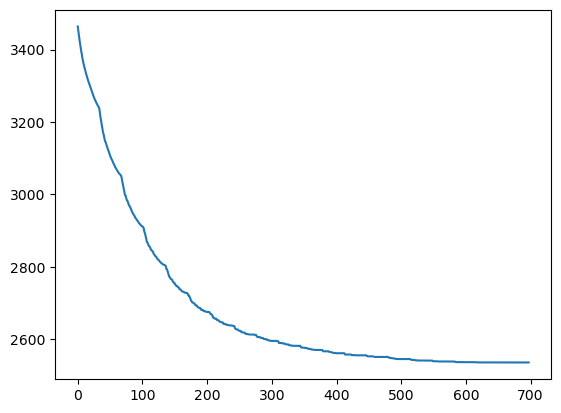

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2521.087
converged after 713 total stimulations.


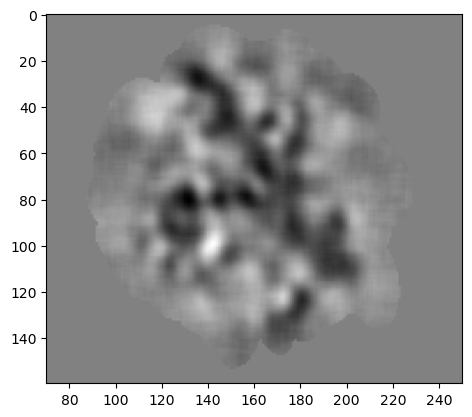

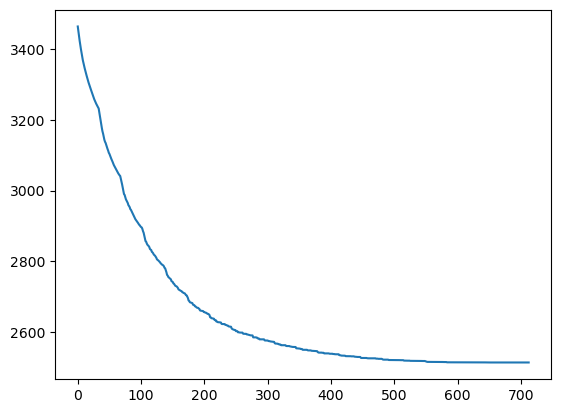

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2471.035
converged after 780 total stimulations.


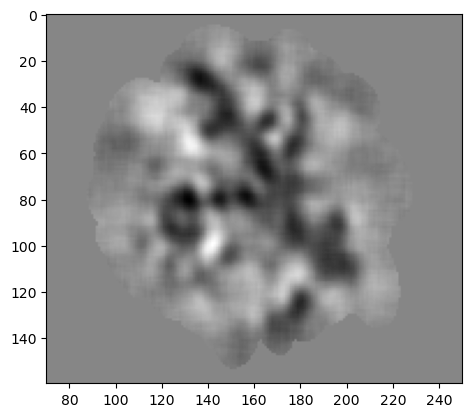

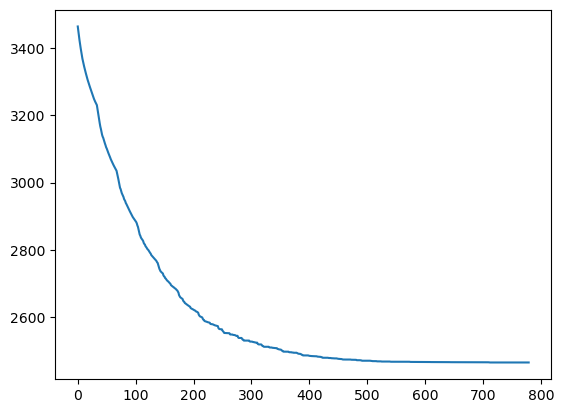

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50  53 181  99 101 160  38
 188  81  82 111]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2463.100
converged after 918 total stimulations.


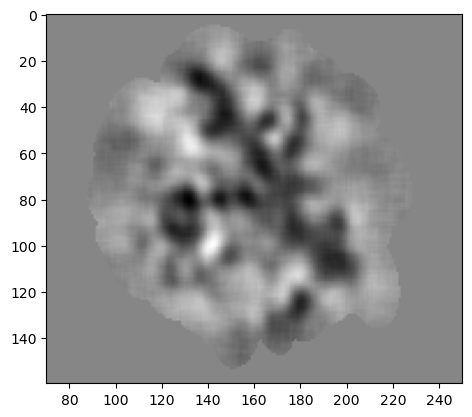

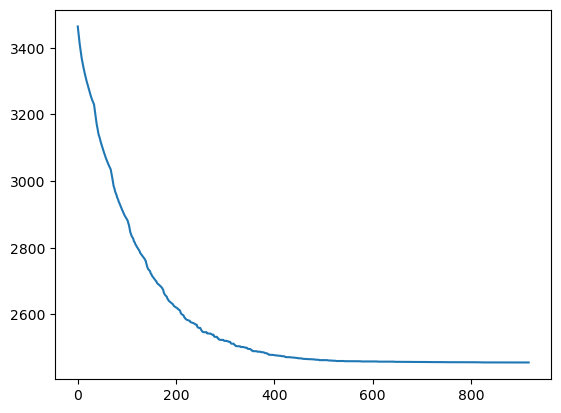

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50  53 181  99 101 160  38
 188  81  82 111 115 119  23  28  29  30  45  46 154  26]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2457.167
converged after 920 total stimulations.


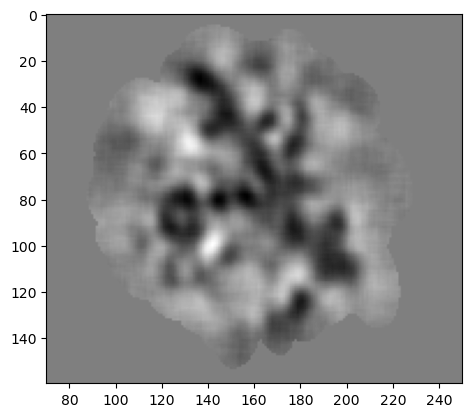

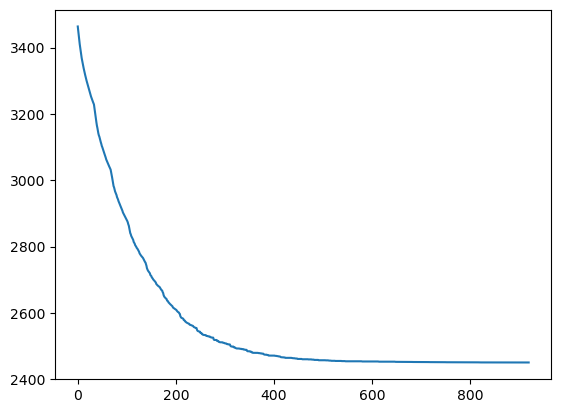

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50  53 181  99 101 160  38
 188  81  82 111 115 119  23  28  29  30  45  46 154  26  65  66 139 144
  33  61  67  51  76 194]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2455.694
converged after 886 total stimulations.


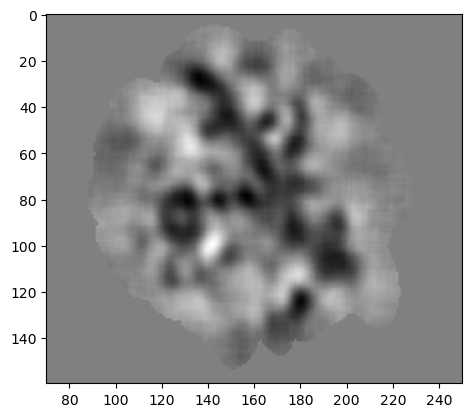

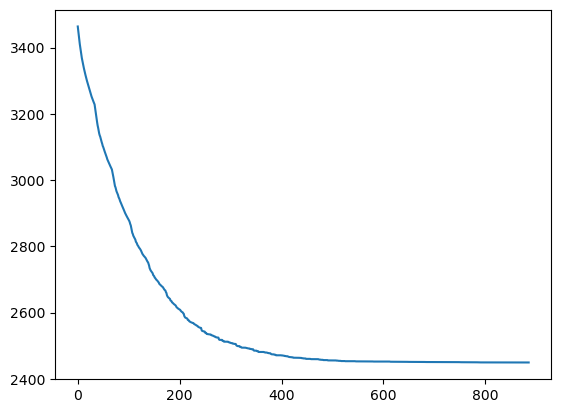

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50  53 181  99 101 160  38
 188  81  82 111 115 119  23  28  29  30  45  46 154  26  65  66 139 144
  33  61  67  51  76 194  17  18  24 173 174  11 130 127 203 129]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2442.188
converged after 898 total stimulations.


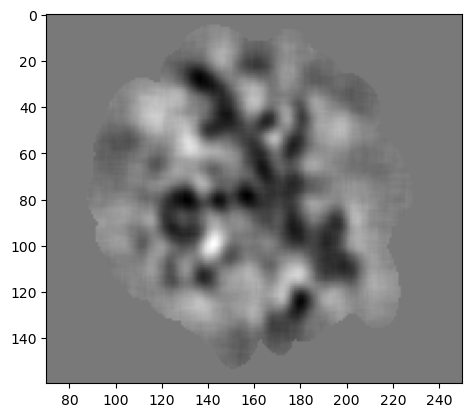

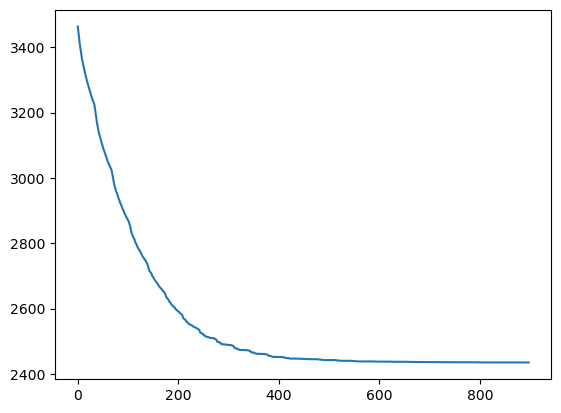

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50  53 181  99 101 160  38
 188  81  82 111 115 119  23  28  29  30  45  46 154  26  65  66 139 144
  33  61  67  51  76 194  17  18  24 173 174  11 130 127 203 129 116 124
 206 171  90  97  98  35  36 212]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2424.654
converged after 972 total stimulations.


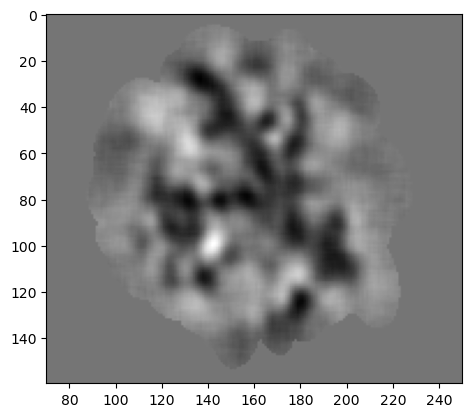

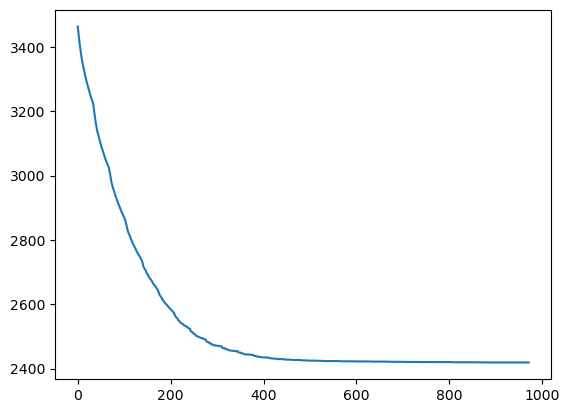

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50  53 181  99 101 160  38
 188  81  82 111 115 119  23  28  29  30  45  46 154  26  65  66 139 144
  33  61  67  51  76 194  17  18  24 173 174  11 130 127 203 129 116 124
 206 171  90  97  98  35  36 212  54 152  47  48  89 190  16 184  96 198]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2411.747
converged after 875 total stimulations.


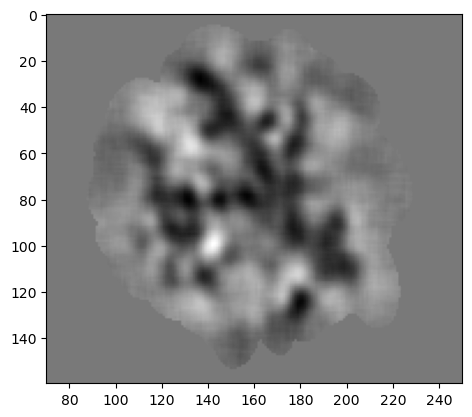

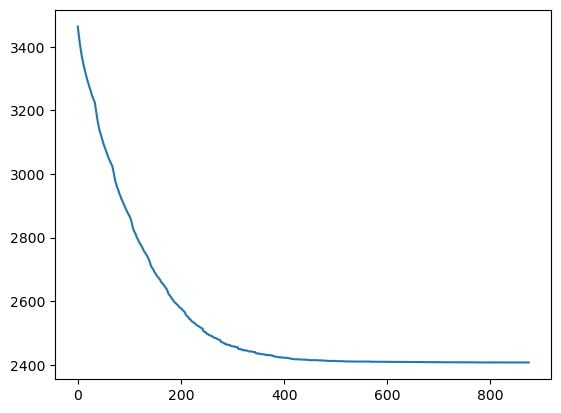

[ 94 100 196 153 161  69  70  72  73 176 177 179 180 156  68  71 191 136
 137 138 207   3   5   6  58  62  63  64  44  50  53 181  99 101 160  38
 188  81  82 111 115 119  23  28  29  30  45  46 154  26  65  66 139 144
  33  61  67  51  76 194  17  18  24 173 174  11 130 127 203 129 116 124
 206 171  90  97  98  35  36 212  54 152  47  48  89 190  16 184  96 198
 103 113  25  27 117 140 141 147 125  19]
stimulation: 0, error: 3463.696
stimulation: 500, error: 2408.856
converged after 875 total stimulations.


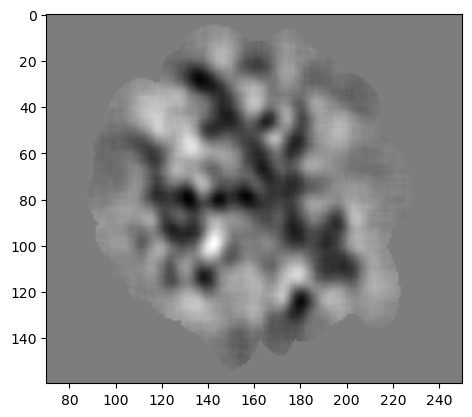

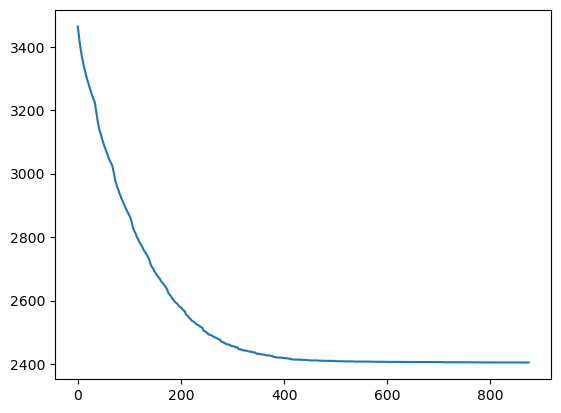

In [36]:
num_cells_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
error_list_el = []

for j in range(len(num_cells_list)):
    num_cells = num_cells_list[j]
    bad_cell_inds = problem_cells[:num_cells]
    print(bad_cell_inds)

    augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[0]))
    for i in range(len(bad_cell_inds)):
        augmented_entries[i, bad_cell_inds[i]] = 1

    dictionary_matrix_aug = np.hstack((dictionary_matrix, augmented_entries.T))
    var_dict_aug = recon.get_dictionary_variance(dictionary_matrix_aug.T,decoding_filters)

    greedy_out_aug = recon.greedy_stim(dictionary_matrix_aug.T,decoding_filters,var_dict_aug,
                                sig_stix,test_stimulus_vector)

    masked_aug = greedy_out_aug['decoded_stimuli'].flatten() * mask

    plt.figure()
    plt.imshow(masked_aug.reshape(160,320),cmap='gray')
    plt.xlim([70,250])
    plt.show()

    plt.figure()
    plt.plot(greedy_out_aug['error_log'])
    plt.show()
    
    error_list_el.append(recon.n_mse(test_stimulus_vector.flatten()[..., None], 
                         greedy_out_aug['decoded_stimuli'], sig_stix))

In [37]:
cell_products = np.zeros(decoding_filters.shape[0])
for i in range(decoding_filters.shape[0]):
    # plt.figure()
    # plt.imshow(decoding_filters[i,:].reshape(RESAMPLE_Y,RESAMPLE_X),cmap='gray')
    # plt.show()

    pixel_mask = (encoding_filters[i, :] != 0).astype(int)

    # plt.figure()
    # plt.imshow((decoding_filters[i, :] * pixel_mask).reshape(160, 320), cmap='gray')
    # plt.show()

    cell_products[i] = ((decoding_filters[i, :] * pixel_mask)**2 @ SE_map_avg / 
                        (np.linalg.norm(SE_map_avg) * np.linalg.norm((decoding_filters[i, :] * pixel_mask)**2)))

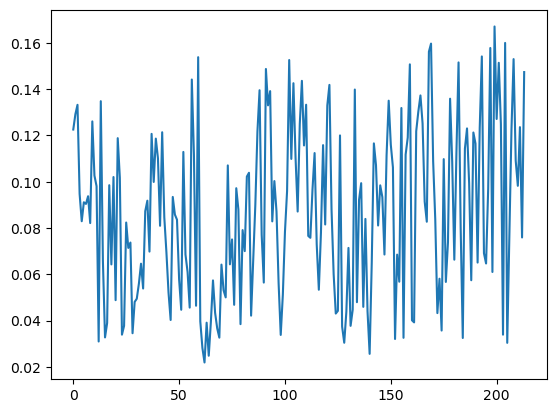

In [38]:
plt.figure()
plt.plot(cell_products)

[199 204 169 197 168 193  59 208 102 182]


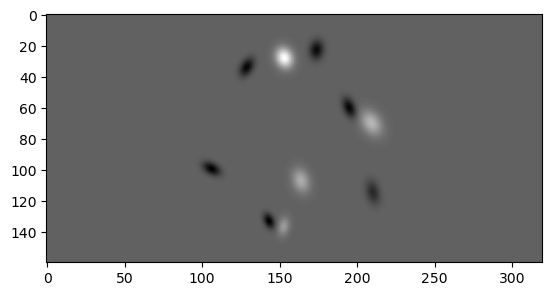

stimulation: 0, error: 3449.175
stimulation: 500, error: 2212.344
stimulation: 1000, error: 2172.161
converged after 1217 total stimulations.


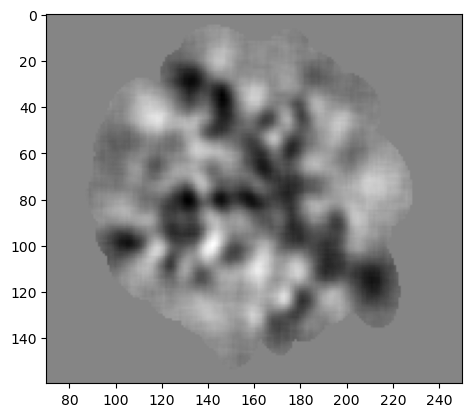

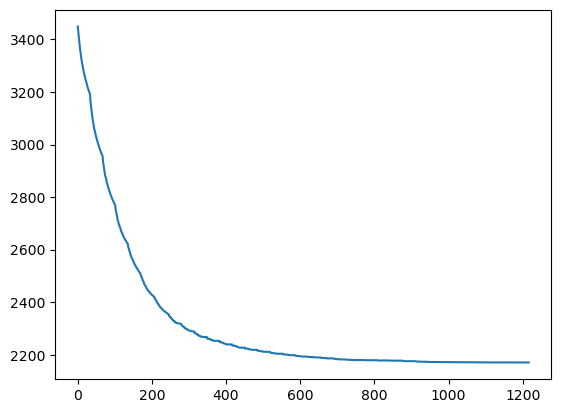

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88]


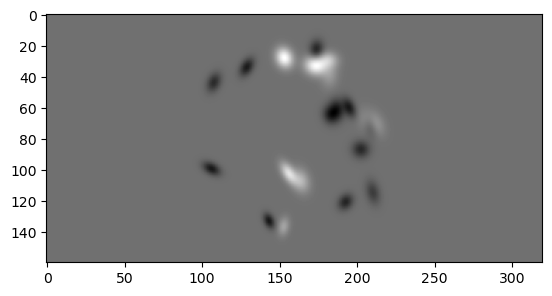

stimulation: 0, error: 3449.175
stimulation: 500, error: 2183.656
stimulation: 1000, error: 2142.596
converged after 1266 total stimulations.


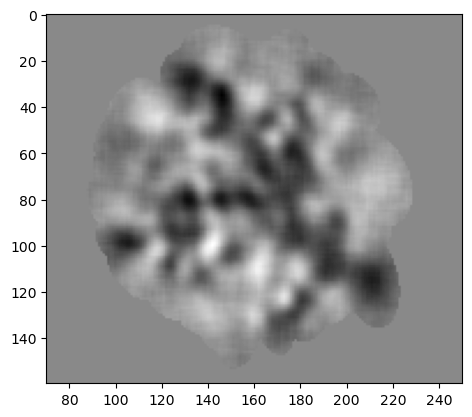

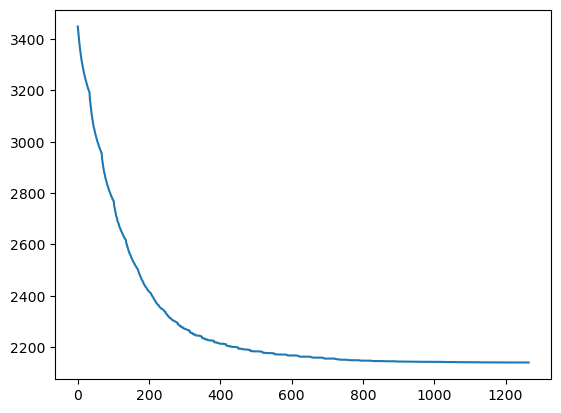

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155]


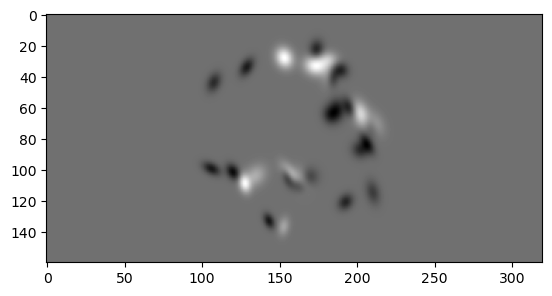

stimulation: 0, error: 3449.175
stimulation: 500, error: 2034.541
stimulation: 1000, error: 1972.203
stimulation: 1500, error: 1960.176
converged after 1509 total stimulations.


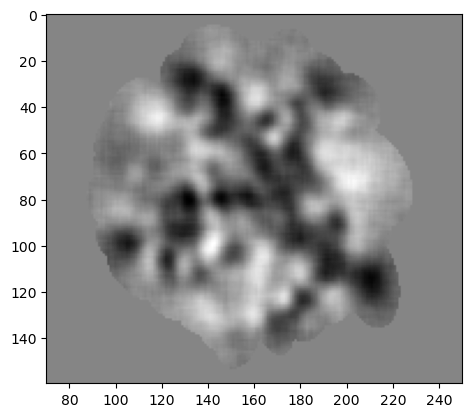

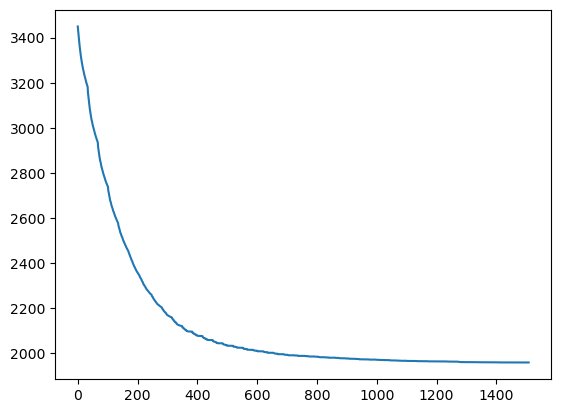

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155 163   1 200   9 165 107
 202 211 192 186]


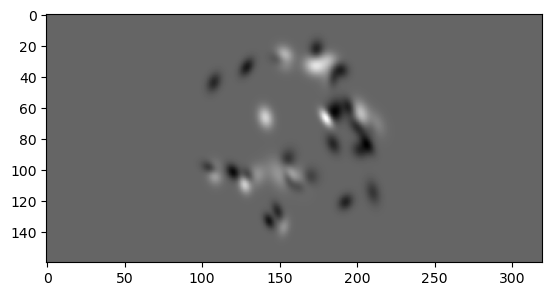

stimulation: 0, error: 3449.175
stimulation: 500, error: 1969.812
stimulation: 1000, error: 1892.206
converged after 1471 total stimulations.


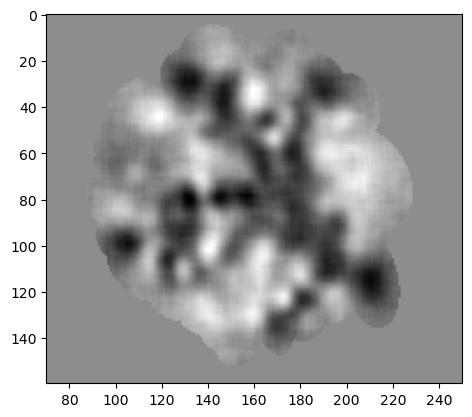

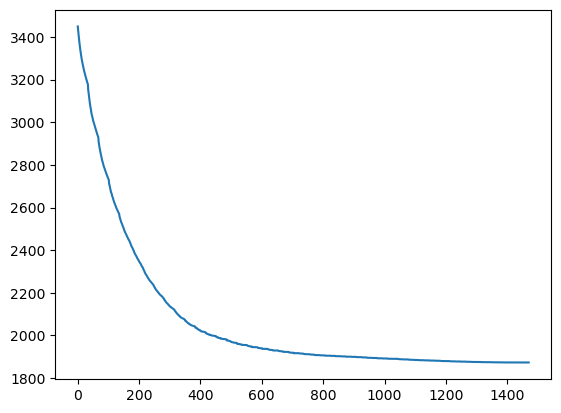

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155 163   1 200   9 165 107
 202 211 192 186 207   0 162  87  42 189  37 126 158  21]


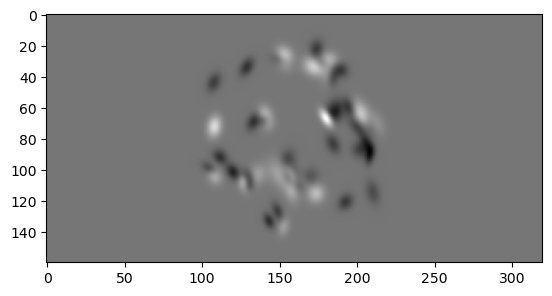

stimulation: 0, error: 3449.175
stimulation: 500, error: 1847.174
stimulation: 1000, error: 1774.979
converged after 1448 total stimulations.


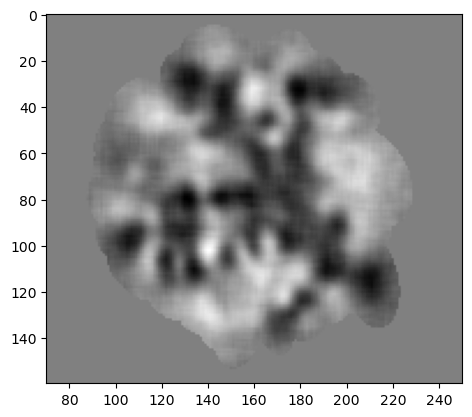

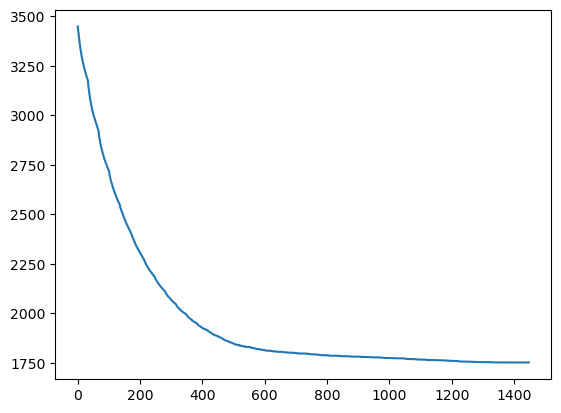

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155 163   1 200   9 165 107
 202 211 192 186 207   0 162  87  42 189  37 126 158  21  39 142 190 150
 118 109 185  52 181 114]


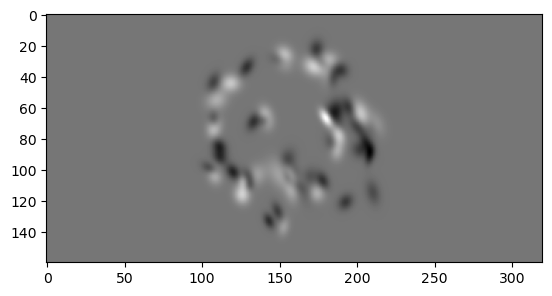

stimulation: 0, error: 3449.175
stimulation: 500, error: 1733.694
stimulation: 1000, error: 1610.941
converged after 1404 total stimulations.


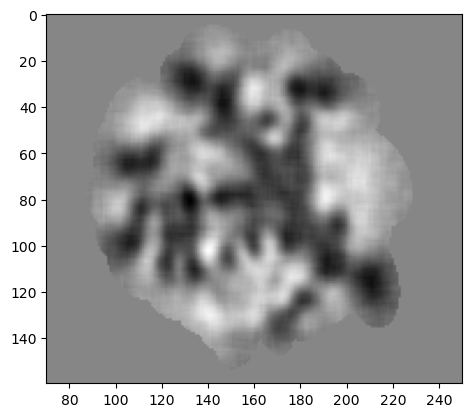

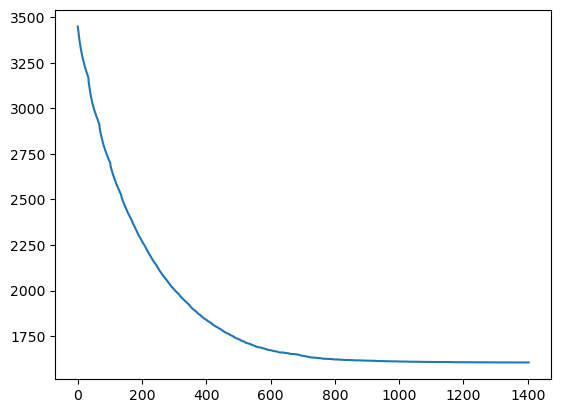

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155 163   1 200   9 165 107
 202 211 192 186 207   0 162  87  42 189  37 126 158  21  39 142 190 150
 118 109 185  52 181 114 157  57 148 105  40 103 175 209 170 179]


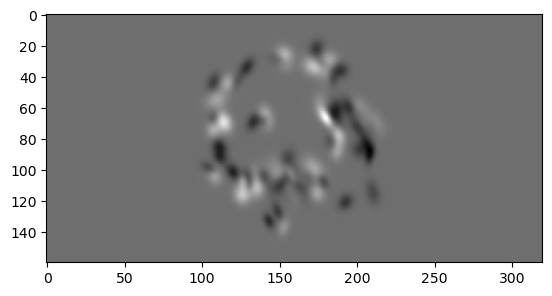

stimulation: 0, error: 3449.175
stimulation: 500, error: 1677.804
stimulation: 1000, error: 1523.822
converged after 1463 total stimulations.


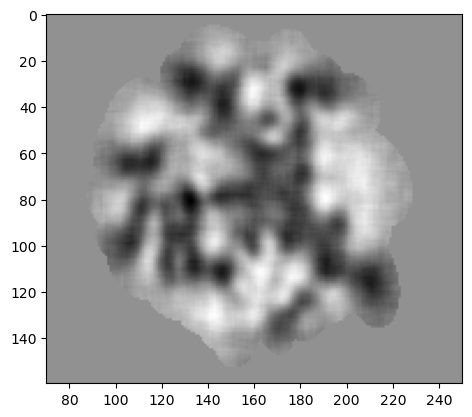

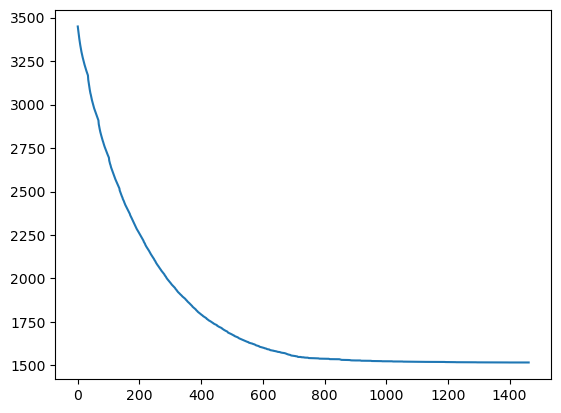

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155 163   1 200   9 165 107
 202 211 192 186 207   0 162  87  42 189  37 126 158  21  39 142 190 150
 118 109 185  52 181 114 157  57 148 105  40 103 175 209 170 179 143  73
 151  83  10  82  19  22  95  38]


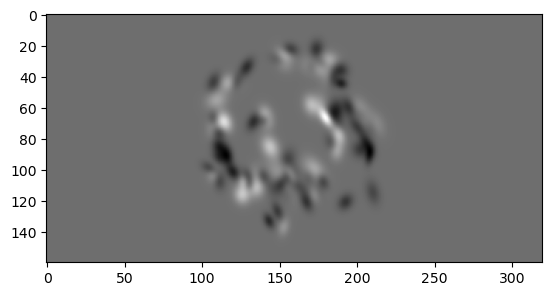

stimulation: 0, error: 3449.175
stimulation: 500, error: 1605.235
stimulation: 1000, error: 1397.016
stimulation: 1500, error: 1373.951
converged after 1576 total stimulations.


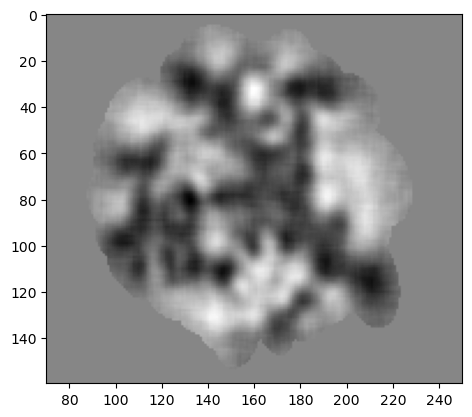

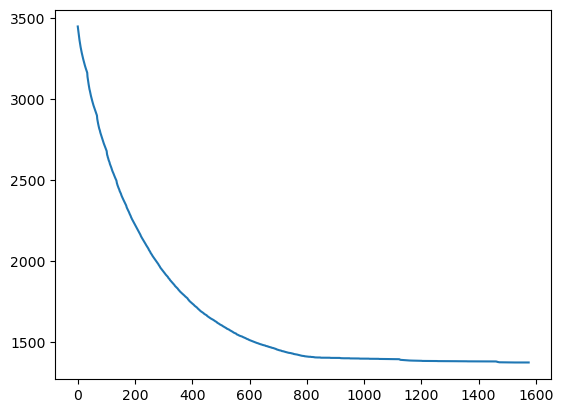

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155 163   1 200   9 165 107
 202 211 192 186 207   0 162  87  42 189  37 126 158  21  39 142 190 150
 118 109 185  52 181 114 157  57 148 105  40 103 175 209 170 179 143  73
 151  83  10  82  19  22  95  38 187 136  17 145 210  11  77 196 113 101]


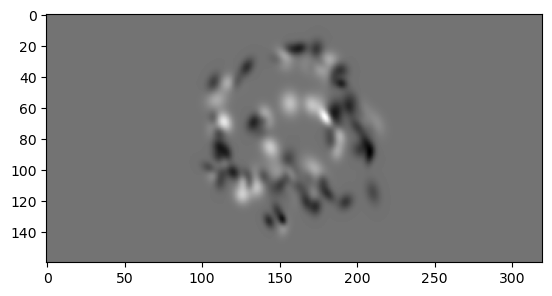

stimulation: 0, error: 3449.175
stimulation: 500, error: 1551.992
stimulation: 1000, error: 1325.905
stimulation: 1500, error: 1310.711
converged after 1565 total stimulations.


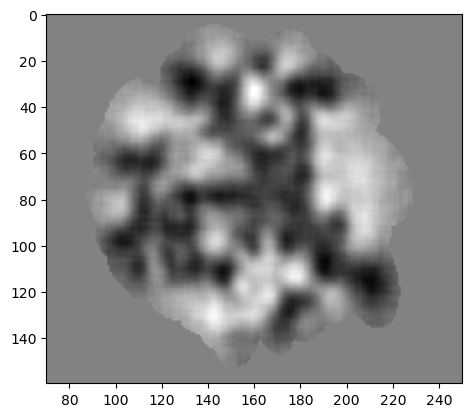

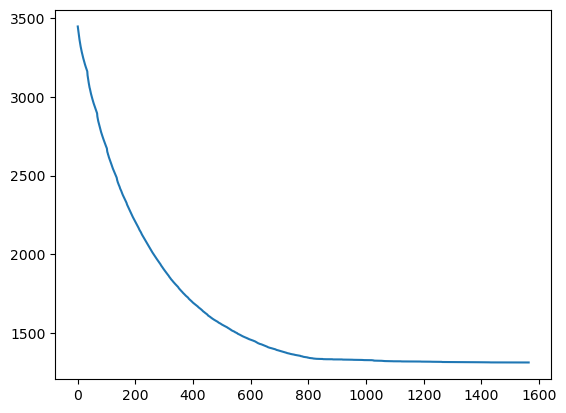

[199 204 169 197 168 193  59 208 102 182 201 159  91 213  56 108 104 121
 133  88  93 164 178 149  13 110   2  92 120 155 163   1 200   9 165 107
 202 211 192 186 207   0 162  87  42 189  37 126 158  21  39 142 190 150
 118 109 185  52 181 114 157  57 148 105  40 103 175 209 170 179 143  73
 151  83  10  82  19  22  95  38 187 136  17 145 210  11  77 196 113 101
   3   7  47 146 135  35 166   5   6  86]


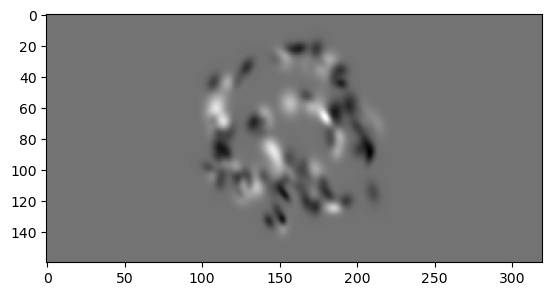

stimulation: 0, error: 3449.175
stimulation: 500, error: 1491.883
stimulation: 1000, error: 1184.896
stimulation: 1500, error: 1164.195
converged after 1669 total stimulations.


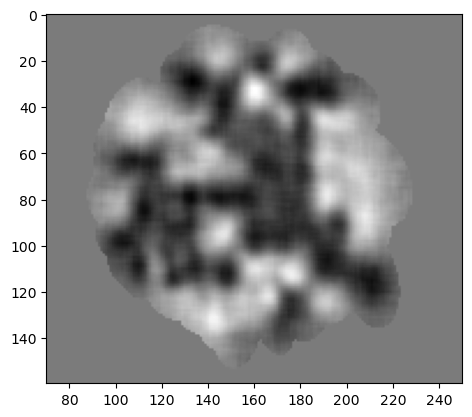

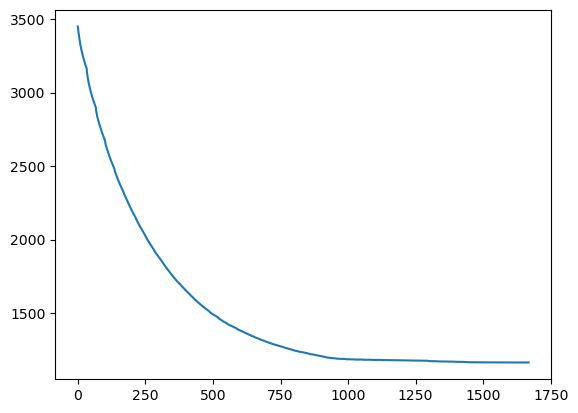

In [39]:
error_list = []

for j in range(len(num_cells_list)):
    num_cells = num_cells_list[j]
    bad_cell_inds = np.flip(np.argsort(cell_products))[:num_cells]
    print(bad_cell_inds)

    bad_superimposed = np.zeros(encoding_filters.shape[1])
    for i in bad_cell_inds:
        bad_superimposed += encoding_filters[i, :]

    plt.figure()
    plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
    plt.show()

    augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[0]))
    for i in range(len(bad_cell_inds)):
        augmented_entries[i, bad_cell_inds[i]] = 1

    dictionary_matrix_aug = np.hstack((dictionary_matrix, augmented_entries.T))
    var_dict_aug = recon.get_dictionary_variance(dictionary_matrix_aug.T,decoding_filters)

    greedy_out_aug = recon.greedy_stim(dictionary_matrix_aug.T,decoding_filters,var_dict_aug,
                                sig_stix,test_stimulus_vector)

    masked_aug = greedy_out_aug['decoded_stimuli'].flatten() * mask

    plt.figure()
    plt.imshow(masked_aug.reshape(160,320),cmap='gray')
    plt.xlim([70,250])
    plt.show()

    plt.figure()
    plt.plot(greedy_out_aug['error_log'])
    plt.show()
    
    error_list.append(recon.n_mse(test_stimulus_vector.flatten()[..., None], 
                      greedy_out_aug['decoded_stimuli'], sig_stix))

[102 121 108  88  59 199 169 204 133  13]


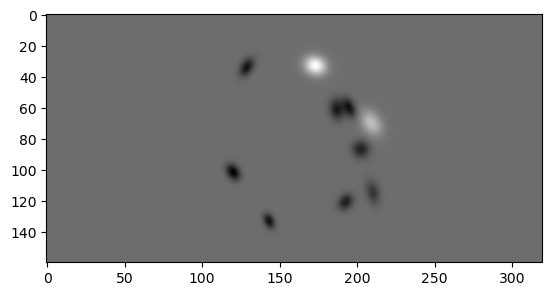

stimulation: 0, error: 3449.175
stimulation: 500, error: 2280.564
stimulation: 1000, error: 2245.020
converged after 1211 total stimulations.


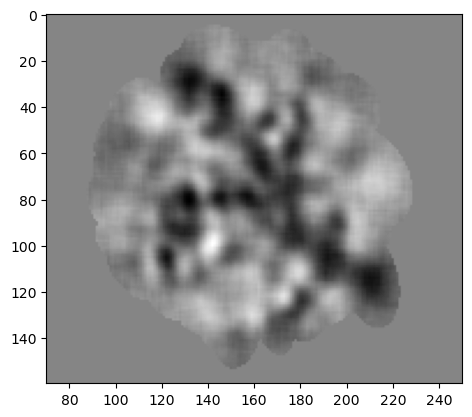

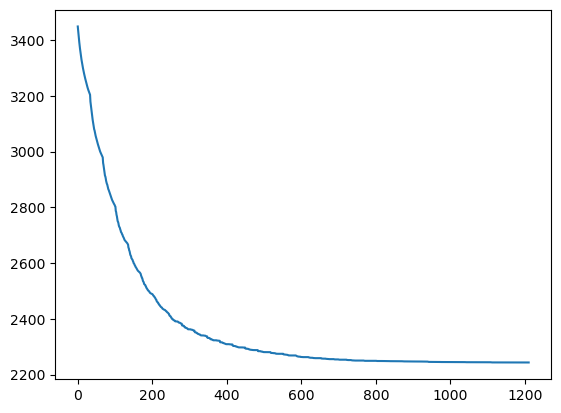

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37]


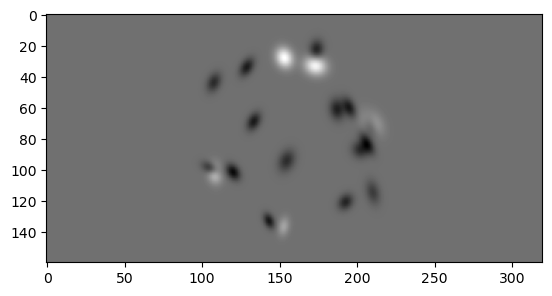

stimulation: 0, error: 3449.175
stimulation: 500, error: 2193.682
stimulation: 1000, error: 2145.810
converged after 1295 total stimulations.


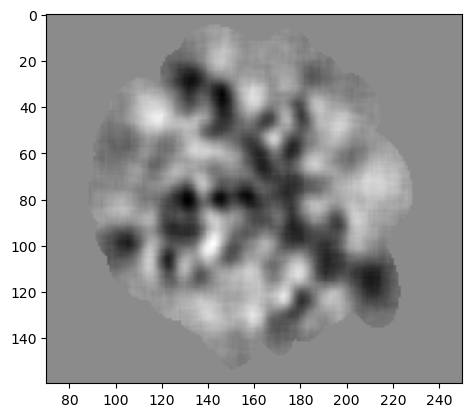

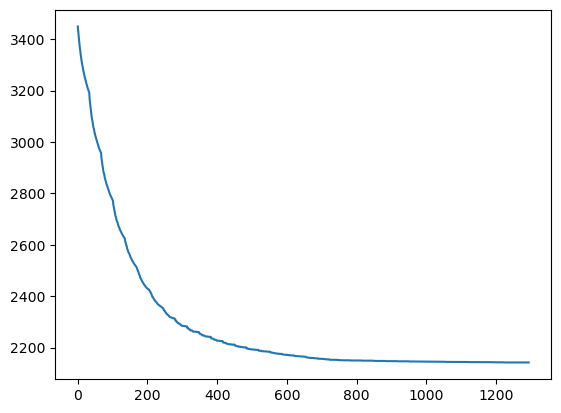

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91]


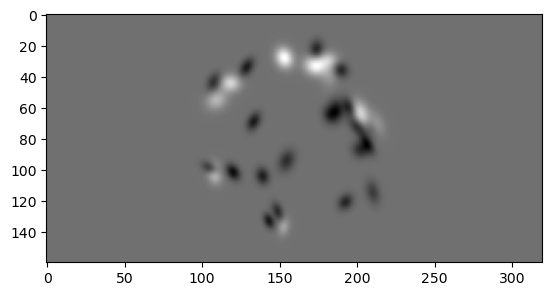

stimulation: 0, error: 3449.175
stimulation: 500, error: 1975.984
stimulation: 1000, error: 1888.964
stimulation: 1500, error: 1876.312
converged after 1502 total stimulations.


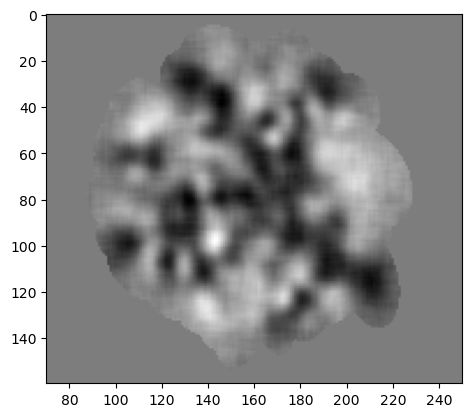

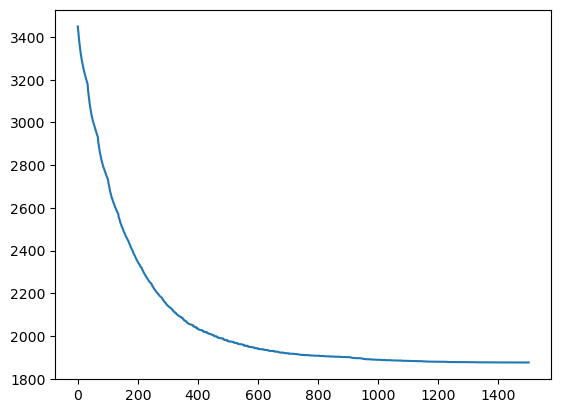

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91 207 208  57 178 181 149
 202 126  83  92]


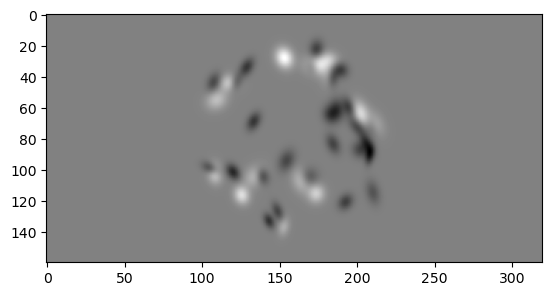

stimulation: 0, error: 3449.175
stimulation: 500, error: 1922.833
stimulation: 1000, error: 1836.567
stimulation: 1500, error: 1809.646
converged after 1625 total stimulations.


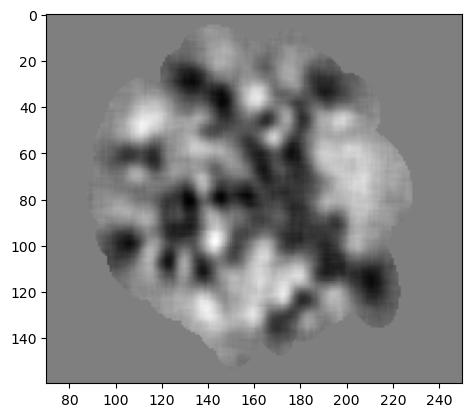

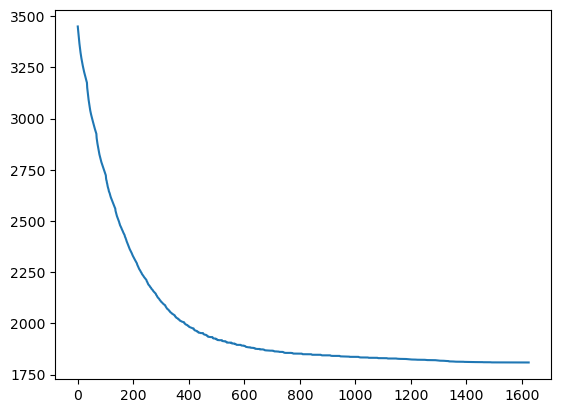

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91 207 208  57 178 181 149
 202 126  83  92 145 187 162 151 143   2 159  19  95 185]


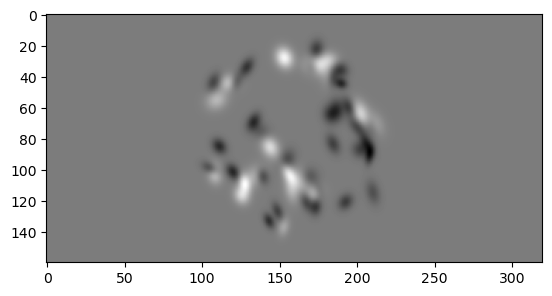

stimulation: 0, error: 3449.175
stimulation: 500, error: 1824.748
stimulation: 1000, error: 1730.289
stimulation: 1500, error: 1719.082
converged after 1519 total stimulations.


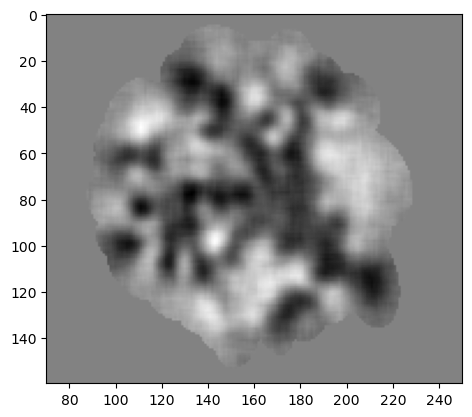

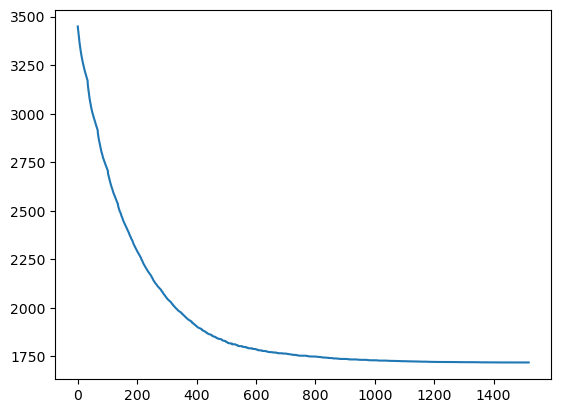

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91 207 208  57 178 181 149
 202 126  83  92 145 187 162 151 143   2 159  19  95 185 196 157 166 142
  10 150   1  21  39 192]


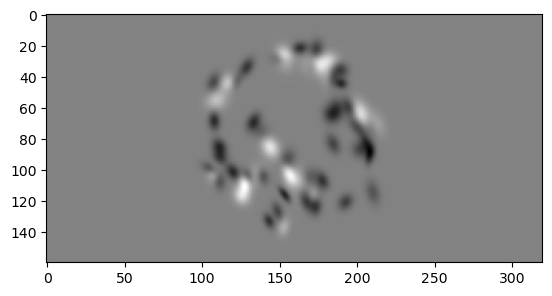

stimulation: 0, error: 3449.175
stimulation: 500, error: 1670.436
stimulation: 1000, error: 1517.683
converged after 1468 total stimulations.


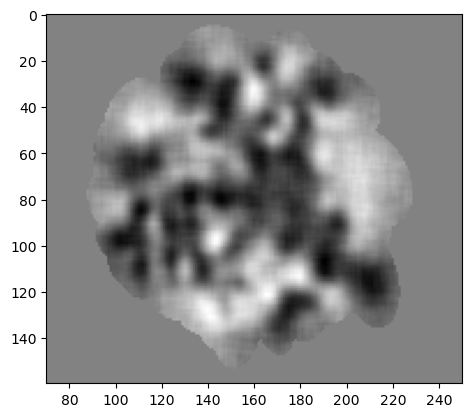

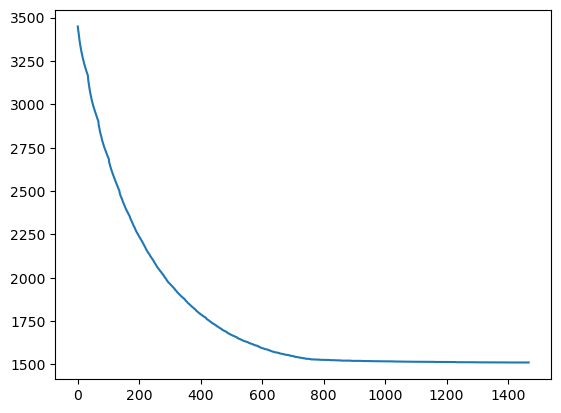

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91 207 208  57 178 181 149
 202 126  83  92 145 187 162 151 143   2 159  19  95 185 196 157 166 142
  10 150   1  21  39 192 105  77  75  73 164 163 155 119  86 148]


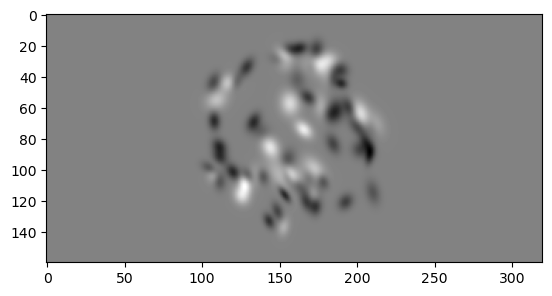

stimulation: 0, error: 3449.175
stimulation: 500, error: 1631.599
stimulation: 1000, error: 1464.331
stimulation: 1500, error: 1442.057
converged after 1519 total stimulations.


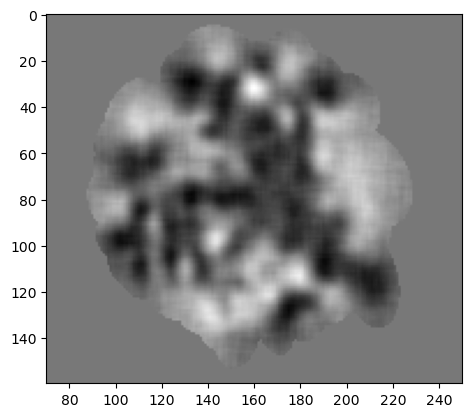

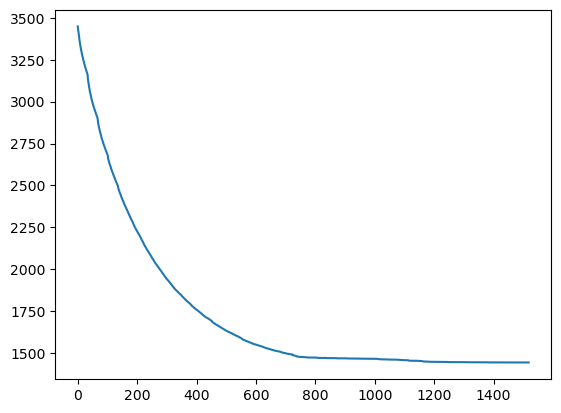

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91 207 208  57 178 181 149
 202 126  83  92 145 187 162 151 143   2 159  19  95 185 196 157 166 142
  10 150   1  21  39 192 105  77  75  73 164 163 155 119  86 148 189 179
  87 206  34 100  80   4 118 186]


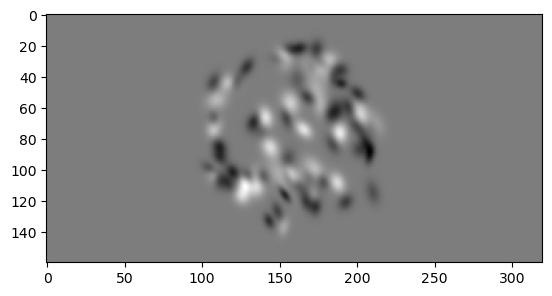

stimulation: 0, error: 3449.175
stimulation: 500, error: 1556.808
stimulation: 1000, error: 1355.953
stimulation: 1500, error: 1343.016
converged after 1928 total stimulations.


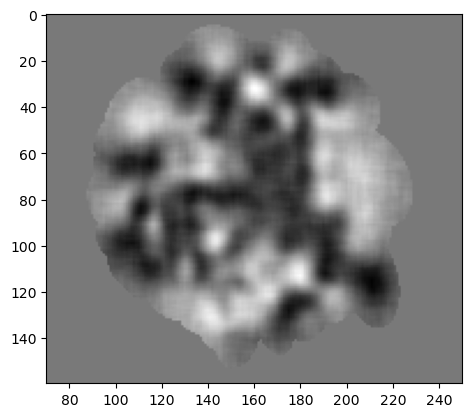

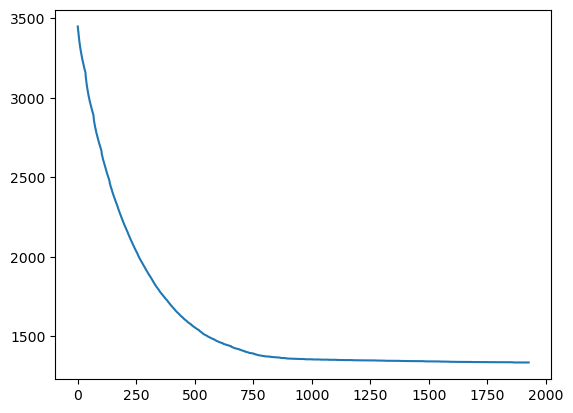

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91 207 208  57 178 181 149
 202 126  83  92 145 187 162 151 143   2 159  19  95 185 196 157 166 142
  10 150   1  21  39 192 105  77  75  73 164 163 155 119  86 148 189 179
  87 206  34 100  80   4 118 186 103  47  42 170 135  85 136 113 158  48]


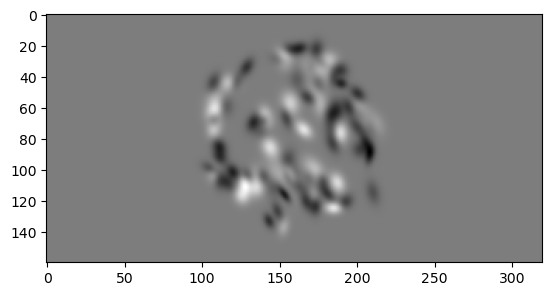

stimulation: 0, error: 3449.175
stimulation: 500, error: 1460.242
stimulation: 1000, error: 1231.103
stimulation: 1500, error: 1207.268
converged after 1923 total stimulations.


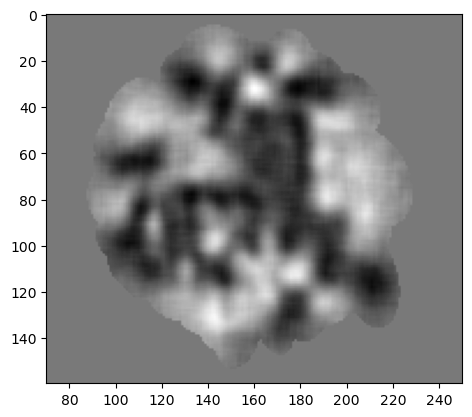

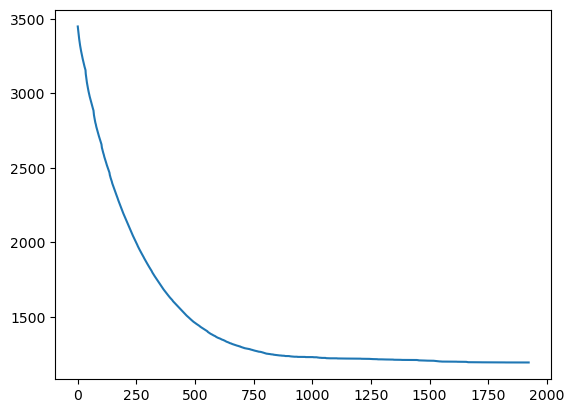

[102 121 108  88  59 199 169 204 133  13 182 168   9 197 193 165  56 201
 120  37  93 213 200 211 190 175 110 104  52  91 207 208  57 178 181 149
 202 126  83  92 145 187 162 151 143   2 159  19  95 185 196 157 166 142
  10 150   1  21  39 192 105  77  75  73 164 163 155 119  86 148 189 179
  87 206  34 100  80   4 118 186 103  47  42 170 135  85 136 113 158  48
 130 101  94  25 210  40   5  36 209  53]


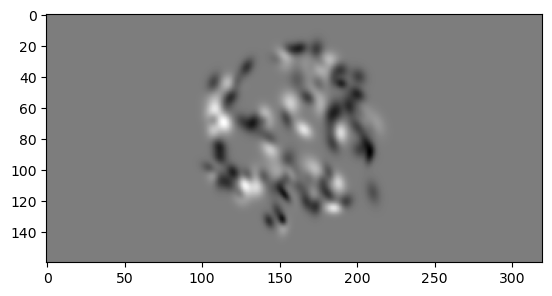

stimulation: 0, error: 3449.175
stimulation: 500, error: 1440.511
stimulation: 1000, error: 1193.984
stimulation: 1500, error: 1180.077
converged after 1938 total stimulations.


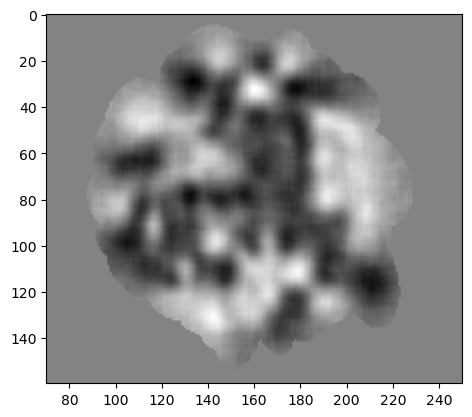

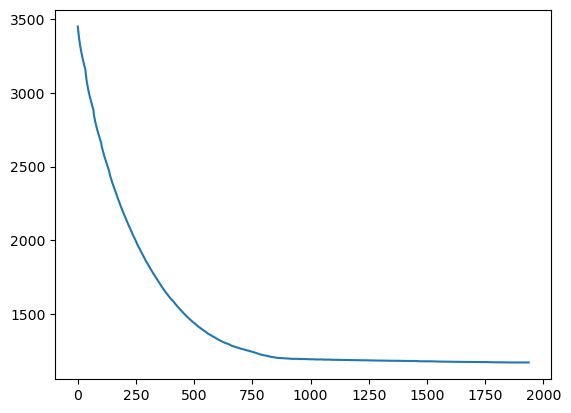

In [40]:
error_list_sp = []

for j in range(len(num_cells_list)):
    num_cells = num_cells_list[j]
    bad_cell_inds = unique_cells[np.flip(np.argsort(counts))][:num_cells]
    print(bad_cell_inds)

    bad_superimposed = np.zeros(encoding_filters.shape[1])
    for i in bad_cell_inds:
        bad_superimposed += encoding_filters[i, :]

    plt.figure()
    plt.imshow(bad_superimposed.reshape(160, 320), cmap='gray')
    plt.show()

    augmented_entries = np.zeros((len(bad_cell_inds), dictionary_matrix.shape[0]))
    for i in range(len(bad_cell_inds)):
        augmented_entries[i, bad_cell_inds[i]] = 1

    dictionary_matrix_aug = np.hstack((dictionary_matrix, augmented_entries.T))
    var_dict_aug = recon.get_dictionary_variance(dictionary_matrix_aug.T,decoding_filters)

    greedy_out_aug = recon.greedy_stim(dictionary_matrix_aug.T,decoding_filters,var_dict_aug,
                                sig_stix,test_stimulus_vector)

    masked_aug = greedy_out_aug['decoded_stimuli'].flatten() * mask

    plt.figure()
    plt.imshow(masked_aug.reshape(160,320),cmap='gray')
    plt.xlim([70,250])
    plt.show()

    plt.figure()
    plt.plot(greedy_out_aug['error_log'])
    plt.show()
    
    error_list_sp.append(recon.n_mse(test_stimulus_vector.flatten()[..., None], 
                         greedy_out_aug['decoded_stimuli'], sig_stix))

In [41]:
dictionary_matrix_sel = np.hstack((np.eye(len(gsorted_cells)),
                                   np.zeros(len(gsorted_cells)).reshape(-1, 1)))
var_dict_sel = recon.get_dictionary_variance(dictionary_matrix_sel.T,decoding_filters)

greedy_out_sel = recon.greedy_stim(dictionary_matrix_sel.T,decoding_filters,var_dict_sel,
                                sig_stix,test_stimulus_vector)

stimulation: 0, error: 3449.175
stimulation: 500, error: 1477.009
stimulation: 1000, error: 1016.327
converged after 1495 total stimulations.


/Volumes/Lab/Development/miniconda-peggyo/envs/gogliettino/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


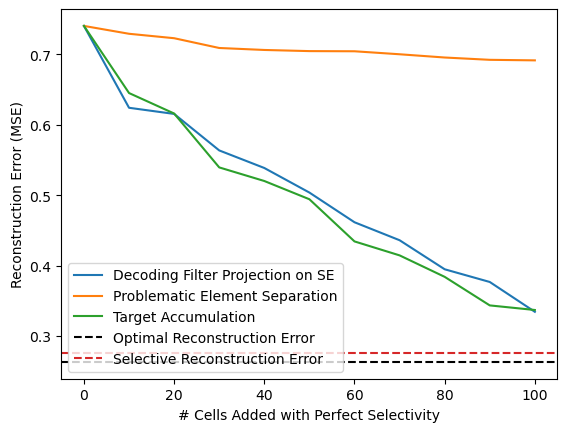

In [42]:
base_err = recon.n_mse(test_stimulus_vector.flatten()[..., None], 
                         greedy_out['decoded_stimuli'], sig_stix)
opt_err = recon.n_mse(test_stimulus_vector.flatten()[..., None], 
                      masked_opt[..., None], sig_stix)
sel_err = recon.n_mse(test_stimulus_vector.flatten()[..., None], 
                      greedy_out_sel['decoded_stimuli'], sig_stix)

plt.figure()
plt.plot([0] + num_cells_list, [base_err] + np.concatenate(error_list).tolist(), 
         label='Decoding Filter Projection on SE')
plt.plot([0] + num_cells_list, [base_err] + np.concatenate(error_list_el).tolist(),
         label='Problematic Element Separation')
plt.plot([0] + num_cells_list, [base_err] + np.concatenate(error_list_sp).tolist(),
         label='Target Accumulation')
plt.axhline(opt_err, linestyle='--', c='k', label='Optimal Reconstruction Error')
plt.axhline(sel_err, linestyle='--', c='tab:red', label='Selective Reconstruction Error')
plt.xlabel('# Cells Added with Perfect Selectivity')
plt.ylabel('Reconstruction Error (MSE)')
plt.legend()
plt.show()